In [1]:
!pip install torch_geometric
!pip install networkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 15.0 MB/s eta 0:00:00


In [2]:
from torch_geometric.datasets import *

import networkx as nx
from torch_geometric.data import Data
from torch_geometric.transforms import BaseTransform
from torch_geometric.utils import to_networkx
from networkit.nxadapter import nx2nk

import numpy as np
from networkit.centrality import Betweenness
from networkit.distance import APSP
from networkit.graph import Graph
from networkit.linkprediction import (
    JaccardIndex,
    CommonNeighborsIndex,
    PreferentialAttachmentIndex,
    AdamicAdarIndex,
    AdjustedRandIndex,
    AlgebraicDistanceIndex,
    KatzIndex
)
from networkit.sparsification import LocalDegreeScore, ForestFireScore
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SGConv
from torch_geometric.nn import Linear

In [3]:
# Triplets (Data, name, dataset_type)

datasets = [
    (Planetoid(root='/tmp/Cora', name='Cora'), 'Cora', 'Planetoid'),
    (Planetoid(root='/tmp/CiteSeer', name='CiteSeer'), 'CiteSeer', 'Planetoid'),
    (Planetoid(root='/tmp/PubMed', name='PubMed'), 'PubMed', 'Planetoid'),
    (Coauthor(root='/tmp/Physics', name='Physics'), 'Physics', 'Coauthor'),
    (Coauthor(root='/tmp/ComputerScience', name='CS'), 'CS', 'Coauthor'),
    #(Reddit(root='/tmp/Reddit'), 'Reddit', 'Reddit'),
    #(TUDataset(root='/tmp/ENZYMES', name='ENZYMES'), 'Enzymes', 'Bioinformatics'),
    #(TUDataset(root='/tmp/PROTEINS', name='PROTEINS'), 'Proteins', 'Bioinformatics'),
    #(TUDataset(root='/tmp/COLLAB', name='COLLAB'), 'Collab', 'Social Networks'),
    #(TUDataset(root='/tmp/AIDS', name='AIDS'), 'AIDS', 'Small Molecules'),
    #(TUDataset(root='/tmp/alchemy_full', name='alchemy_full'), 'alchemy_full', 'Small Molecules'),
    #(TUDataset(root='/tmp/benzene', name='benzene'), 'benzene', 'Small Molecules'),
    #(TUDataset(root='/tmp/aspirin', name='aspirin'), 'aspirin', 'Small Molecules'),
    #(WikiCS(root='/tmp/WikiCS'), 'WikiCS', 'Social')
    ]

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [4]:
class GCN_CUSTOM(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dataset.num_node_features)
        self.conv2 = GCNConv(dataset.num_node_features, dataset.num_node_features)
        self.lin1 = Linear(dataset.num_node_features, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.lin1(x)

        return F.log_softmax(x, dim=1)

In [5]:
class SGC(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = SGConv(dataset.num_node_features, dataset.num_node_features, K=2)
        self.conv2 = SGConv(dataset.num_node_features, dataset.num_node_features, K=2)
        self.lin1 = Linear(dataset.dataset.num_node_features, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.lin1(x)

        return F.log_softmax(x, dim=1)

In [6]:
from torch_geometric.nn.models import GCN, GraphSAGE, GIN, PNA, GAT

In [7]:
def calculate_shortest_paths(graph: Graph) -> np.array:
    # Networkit is faster than NetworkX for large graphs
    apsp = APSP(graph)
    apsp.run()
    path_lengths = apsp.getDistances(asarray=True)

    path_lengths = path_lengths.ravel()

    # filter out 0 length "paths" from node to itself
    path_lengths = path_lengths[np.nonzero(path_lengths)]

    # Networkit assigns extremely high values (~1e308) to mark infinite
    # distances for disconnected components, so we simply drop them
    path_lengths = path_lengths[path_lengths < 1e100]

    return path_lengths


def calculate_edge_betweenness(graph: Graph) -> np.ndarray:
    betweeness = Betweenness(graph, computeEdgeCentrality=True)
    betweeness.run()
    scores = betweeness.edgeScores()
    scores = np.array(scores, dtype=np.float32)
    return scores


In [8]:
class Calculate:
    def __init__(self, method, minmax=False, norm=False):
        self._method = method
        self._minmax = minmax
        self._norm = norm

    def run(self, graph: Graph) -> np.ndarray:
        index = self._method(graph)
        scores = [index.run(u, v) for u, v in graph.iterEdges()]
        scores = np.array(scores, dtype=np.float32)
        scores = scores[np.isfinite(scores)]
        if self._norm:
            scores = (scores - np.mean(scores)) / (np.std(scores) + np.finfo(np.float32).eps)
        if self._minmax:
            scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores) + np.finfo(np.float32).eps)
        return scores


class JaccardCalc(Calculate):
    def __init__(self, method=JaccardIndex, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)


class CommonNeighborsCalc(Calculate):
    def __init__(self, method=CommonNeighborsIndex, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)


class PreferentialAttachmentCalc(Calculate):
    def __init__(self, method=PreferentialAttachmentIndex, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)


class AdamicAdarCalc(Calculate):
    def __init__(self, method=AdamicAdarIndex, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)


class AdjustedRandCalc(Calculate):
    def __init__(self, method=AdjustedRandIndex, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)


class AlgebraicDistanceCalc(Calculate):
    def __init__(self, method=AlgebraicDistanceIndex, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)


class KatzCalc(Calculate):
    def __init__(self, method=KatzIndex, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)


def calculate_local_degree_score(graph: Graph) -> np.ndarray:
    local_degree_score = LocalDegreeScore(graph)
    local_degree_score.run()
    scores = local_degree_score.scores()
    return np.array(scores, dtype=np.float32)


class LDSCalc(Calculate):
    def __init__(self, method=LocalDegreeScore, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)

    def run(self, graph: Graph) -> np.ndarray:
        local_degree_score = self._method(graph)
        local_degree_score.run()
        scores = local_degree_score.scores()
        scores = np.array(scores, dtype=np.float32)
        scores = scores[np.isfinite(scores)]
        return scores


class FFSCalc(Calculate):
    def __init__(self, method=ForestFireScore, minmax=False, norm=True):
        super().__init__(method, minmax=minmax, norm=norm)

    def run(self, graph: Graph) -> np.ndarray:
        forest_fire = self._method(graph, 0.5, 1.0)
        forest_fire.run()
        scores = forest_fire.scores()
        scores = np.array(scores, dtype=np.float32)
        scores = scores[np.isfinite(scores)]
        return scores

In [9]:
class BaseSparsing(BaseTransform):
    def __init__(self, power: float=None):
        super(BaseSparsing, self).__init__()
        self.power = power

    def __call__(self, data: Data) -> Data:
        raise NotImplementedError


class Random(BaseSparsing):
    def __init__(self, power: float=None):
        super(Random, self).__init__(power=power)

    def __call__(self, data: Data) -> Data:
        if self.power is not None:
            edge_index = data.edge_index
            percentage_num_nodes = int(edge_index.size(1) * self.power)
            data.edge_index = edge_index[:, :-percentage_num_nodes]
        return data

    def f(self, data: Data) -> Data:
        return self.__call__(data)

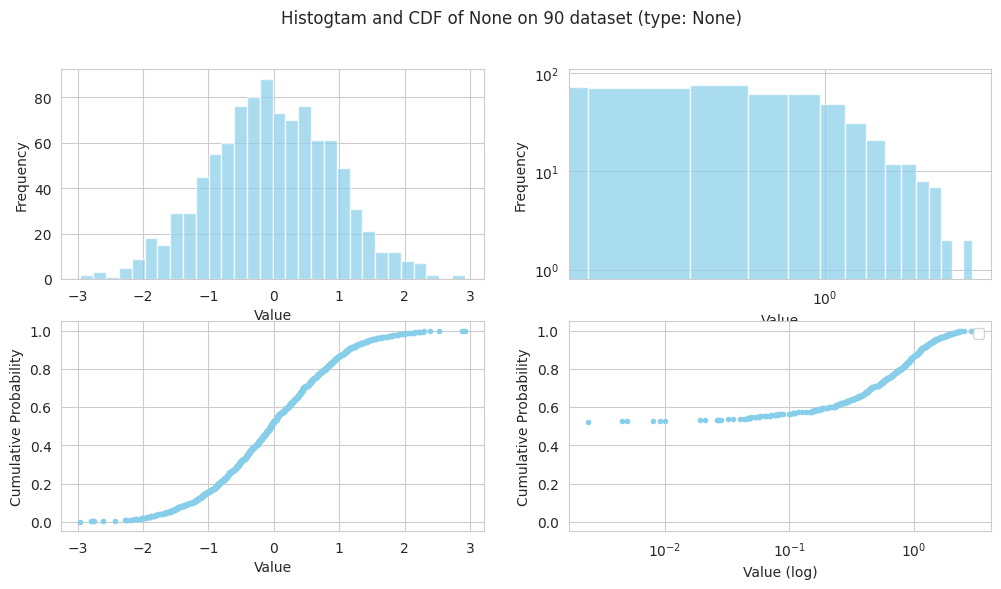

In [10]:
import matplotlib.pyplot as plt

def show_histogram(data):
    plt.hist(data, bins=30, density=False, alpha=0.7, color='skyblue')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.xscale('log')
    plt.yscale('log')

    plt.title('Histogram of Values')
    plt.show()

def show_histogram2(data, percentile_threshold=95):
    """
    Plots a histogram of the data and prints the x-value corresponding to the
    specified percentile threshold.

    Args:
        data (numpy.ndarray): The data to plot.
        percentile_threshold (float): The percentile threshold to calculate (default is 95).
    """

    # Calculate the value at the specified percentile
    threshold_value = np.percentile(data, percentile_threshold)

    # Plot the histogram
    plt.hist(data, bins=30, density=False, alpha=0.7, color='skyblue')
    plt.xlabel('Value')
    plt.xscale('log')
    plt.yscale('log')

    plt.ylabel('Frequency')
    plt.title(f'Histogram of Values (Threshold at {percentile_threshold}%: {threshold_value:.2f})')

    # Add a vertical line at the threshold
    plt.axvline(x=threshold_value, color='red', linestyle='dashed', linewidth=1, label=f'{percentile_threshold}% Threshold')

    # Add legend
    plt.legend()

    # Print the threshold value
    print(f"Value at {percentile_threshold}% threshold: {threshold_value:.2f}")

    plt.show()

import numpy as np
import matplotlib.pyplot as plt

def show_cdf(data, dataset: str=None, data_type: str=None, algo: str=None):
    """
    Plots the cumulative distribution function (CDF) of the data and
    prints the x-value corresponding to the specified percentile threshold.

    Args:
        data (numpy.ndarray): The data to plot.
        percentile_threshold (float): The percentile threshold to calculate (default is 95).
    """

    # Sort the data
    sorted_data = np.sort(data)

    # Calculate the CDF values (cumulative probabilities)
    cdf_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    # Calculate the value at the specified percentile
    #threshold_value = np.percentile(data, percentile_threshold)

    # Plot the CDF
    fig, ax = plt.subplots(2, 2, figsize=(12, 6))

    ax1 = ax[0, 0]

    ax1.hist(sorted_data, bins=30, density=False, alpha=0.7, color='skyblue')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')

    ax2 = ax[0, 1]

    ax2.hist(sorted_data, bins=30, density=False, alpha=0.7, color='skyblue')
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Frequency')
    ax2.set_xscale('log')
    ax2.set_yscale('log')

    ax3 = ax[1, 0]

    ax3.plot(sorted_data, cdf_values, marker='.', linestyle='none', color='skyblue')
    ax3.set_xlabel('Value')

    ax3.set_ylabel('Cumulative Probability')
    #ax1.title.set_text(f'CDF of {algo} on {dataset} dataset (type: {data_type})')

    ax4 = ax[1, 1]

    ax4.plot(sorted_data, cdf_values, marker='.', linestyle='none', color='skyblue')
    ax4.set_xlabel('Value (log)')
    ax4.set_xscale('log')

    ax4.set_ylabel('Cumulative Probability')

    ax1.title.set_text('')
    ax2.title.set_text('')
    ax3.title.set_text('')
    ax4.title.set_text('')
    # ax2.title.set_text(f'CDF (log x scale) of {algo} on {dataset} dataset (type: {data_type})')

    # Add a horizontal line at the threshold and a vertical line at the corresponding x-value
    #plt.axhline(y=percentile_threshold / 100, color='red', linestyle='dashed', linewidth=1, label=f'{percentile_threshold}% Threshold')
    #plt.axvline(x=threshold_value, color='red', linestyle='dashed', linewidth=1)

    fig.suptitle(f'Histogtam and CDF of {algo} on {dataset} dataset (type: {data_type})')

    # Add legend
    plt.legend()

    # Print the threshold value
    #print(f"Value at {percentile_threshold}% threshold: {threshold_value:.2f}")

    plt.show()

# Example usage
data = np.random.normal(0, 1, 1000)  # Generate some data
show_cdf(data, 90)  # Change the percentile threshold as needed

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class IndexMain(BaseSparsing):
    def __init__(self, power: int=None, calc=None, calc_name=None):
        super(IndexMain, self).__init__(power=power)
        self._calc = calc
        self._calc_name = calc_name

    def _main_calc(self, G):
        return self._calc.run(G)

    def __call__(self, data: Data, data_name: str, data_type: str) -> Data:
        if self.power is not None:
            edge_index = data.edge_index
            mask = edge_index[0] < edge_index[1]
            edge_index = edge_index[:, mask]
            G = to_networkx(data, to_undirected=True)
            G = nx2nk(G)
            G.removeSelfLoops()
            G.indexEdges()
            edge_weights = self._main_calc(G)
            show_cdf(edge_weights, data_name, data_type, self._calc_name)
            edge_index = edge_index[:, edge_weights >= self.power]
            edge_index = torch.cat([edge_index, torch.flip(edge_index, dims=[0])], dim=1)
            data.edge_index = edge_index
        return data

    def f(self, data: Data) -> Data:
        return self.__call__(data)


class Jaccard(IndexMain):
    def __init__(self, power: int = None, calc=JaccardCalc(minmax=True), calc_name='Jaccard'):
        super(Jaccard, self).__init__(power=power, calc=calc, calc_name=calc_name)


class CommonNeighbor(IndexMain):
    def __init__(self, power: int = None, calc=CommonNeighborsCalc(minmax=True), calc_name='CommonNeighbor'):
        super(CommonNeighbor, self).__init__(power=power, calc=calc, calc_name=calc_name)


class PreferentialAttachment(IndexMain):
    def __init__(self, power: int = None, calc=PreferentialAttachmentCalc(minmax=True), calc_name='PreferentialAttachment'):
        super(PreferentialAttachment, self).__init__(power=power, calc=calc, calc_name=calc_name)


class AdamicAdar(IndexMain):
    def __init__(self, power: int = None, calc=AdamicAdarCalc(minmax=True), calc_name='AdamicAdar'):
        super(AdamicAdar, self).__init__(power=power, calc=calc, calc_name=calc_name)


class AdjustedRand(IndexMain):
    def __init__(self, power: int = None, calc=AdjustedRandCalc(minmax=True), calc_name='AdjustedRand'):
        super(AdjustedRand, self).__init__(power=power, calc=calc, calc_name=calc_name)


class AlgebraicDistance(IndexMain):
    def __init__(self, power: int = None, calc=AlgebraicDistanceCalc(minmax=True), calc_name='AlgebraicDistance'):
        super(AlgebraicDistance, self).__init__(power=power, calc=calc, calc_name=calc_name)


class Katz(IndexMain):
    def __init__(self, power: int = None, calc=KatzCalc(minmax=True), calc_name='Katz'):
        super(Katz, self).__init__(power=power, calc=calc, calc_name=calc_name)


class LDS(IndexMain):
    def __init__(self, power: int = None, calc=LDSCalc(minmax=True), calc_name='Local Degree Score'):
        super().__init__(power=power, calc=calc, calc_name=calc_name)


class ForestFire(IndexMain):
    def __init__(self, power: int = None, calc=FFSCalc(minmax=True), calc_name='Forest Fire'):
        super().__init__(power=power, calc=calc, calc_name=calc_name)


In [11]:
def run_exp(dataset, sparsing_alg=None, model_type=GCN):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_type(dataset).to(device)
    data = dataset[0].to(device)
    if sparsing_alg is not None:
        data = sparsing_alg.f(data)
    return 1.0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

PreferentialAttachment()
Cora


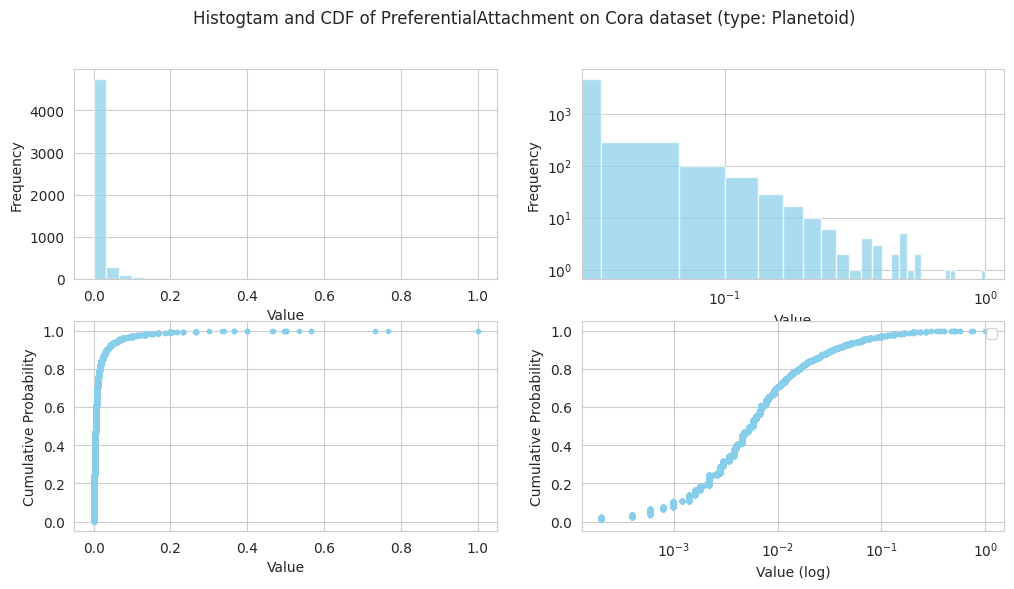

Jaccard()
Cora


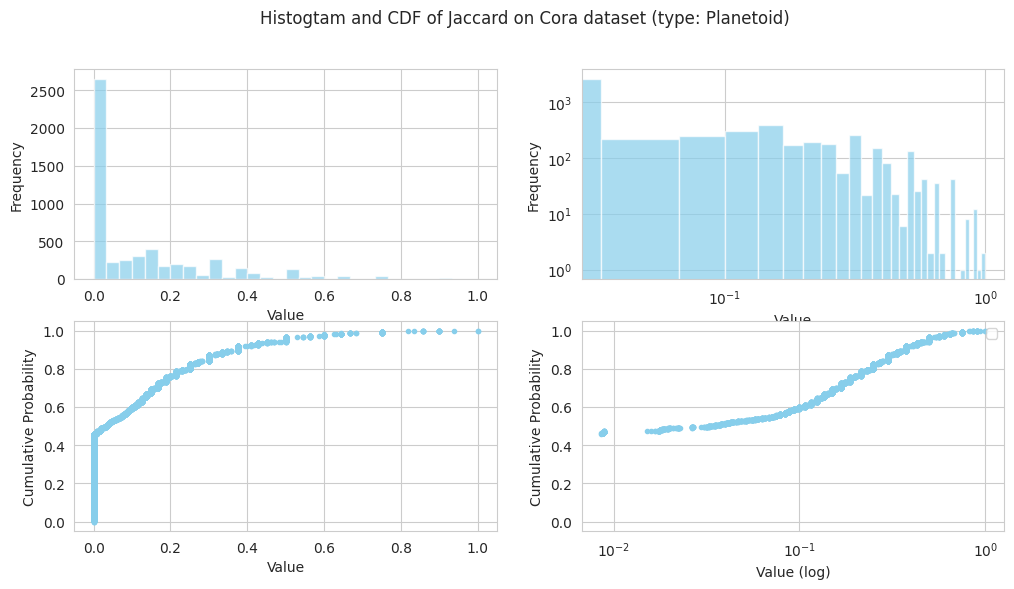

CommonNeighbor()
Cora


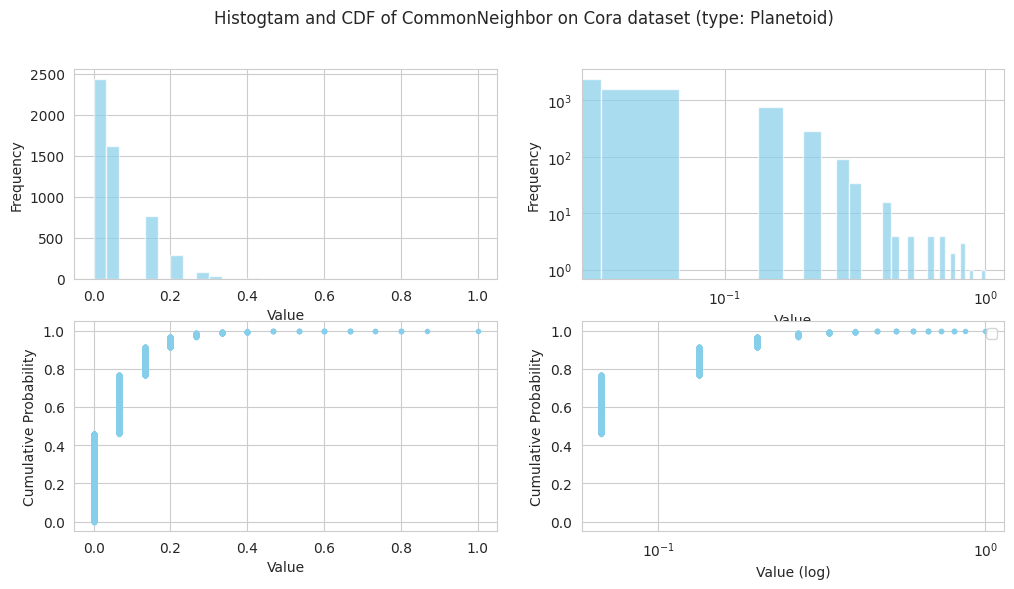

AdamicAdar()
Cora


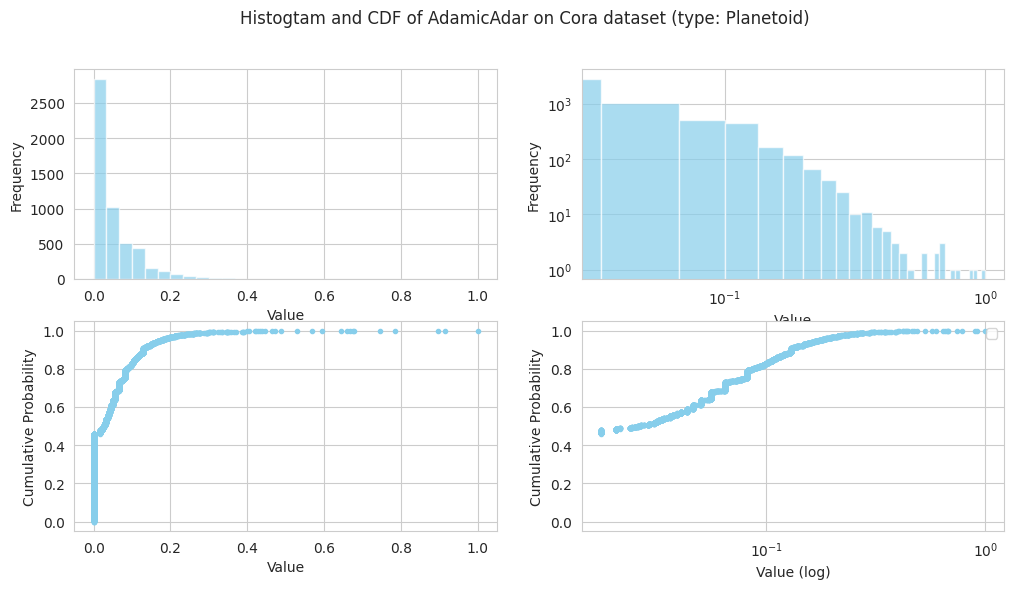

AdjustedRand()
Cora


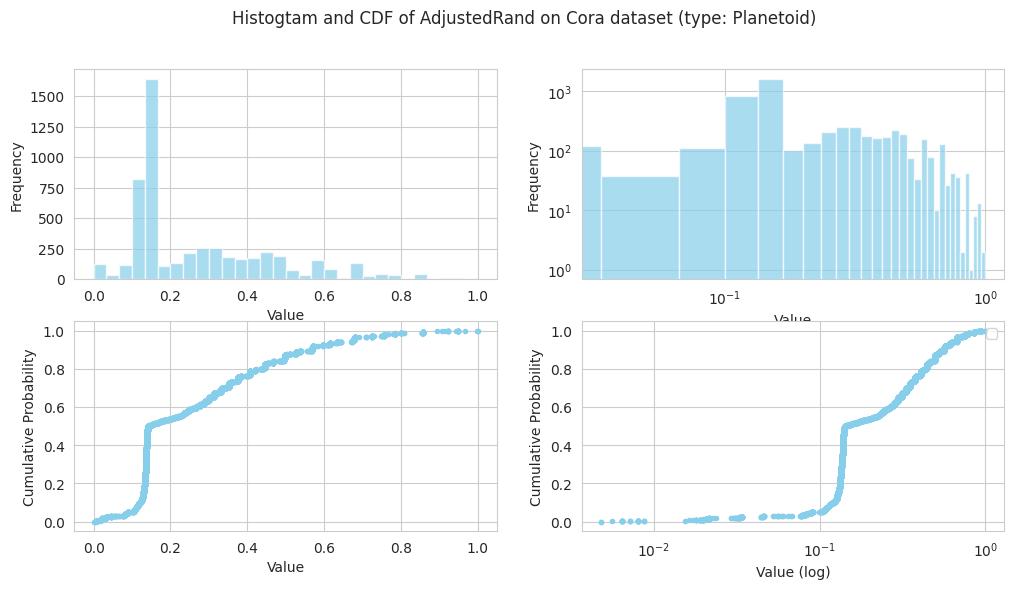

Katz()
Cora


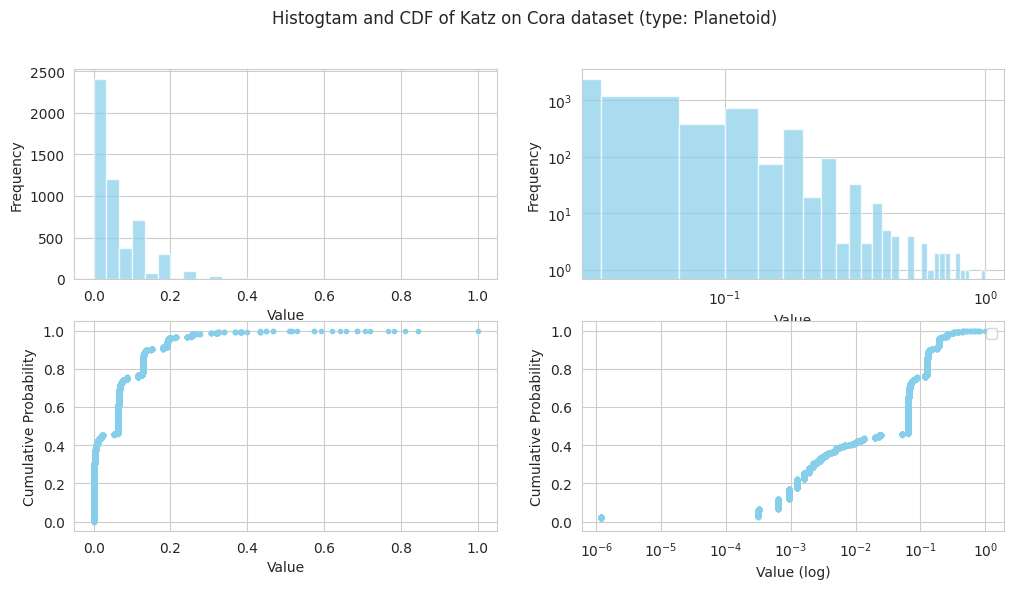

LDS()
Cora


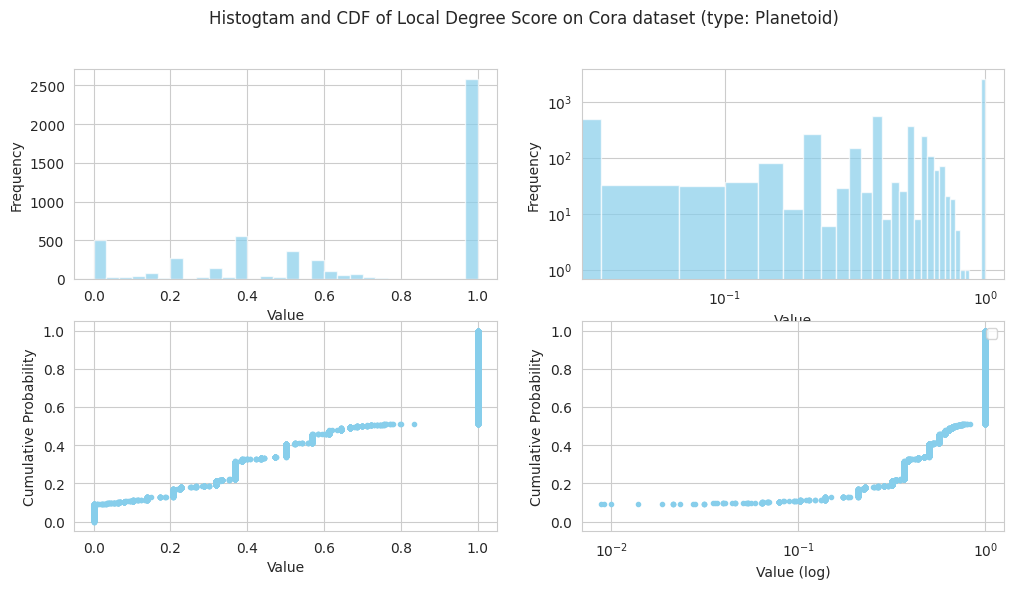

ForestFire()
Cora


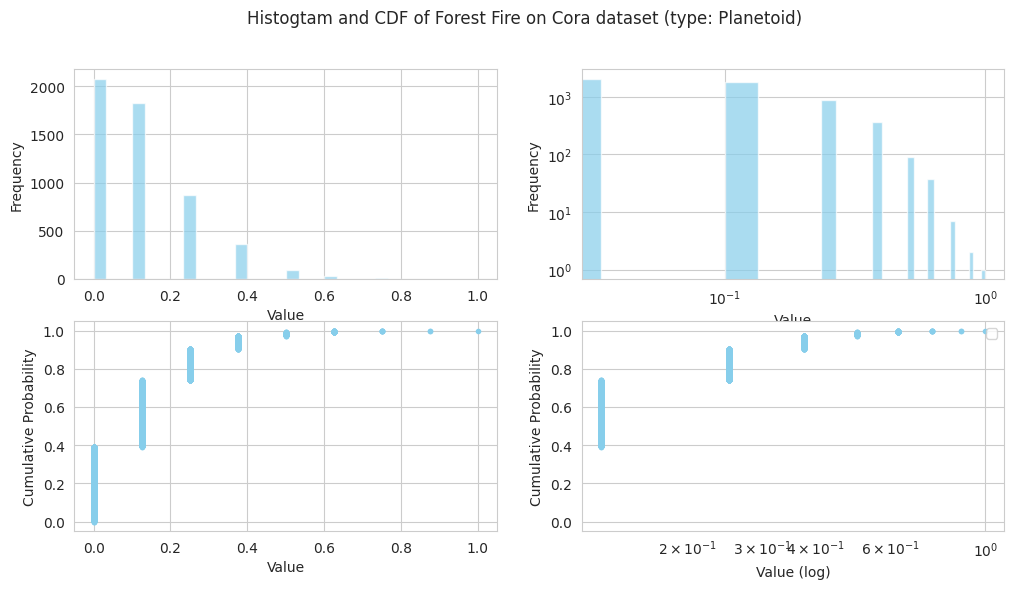

PreferentialAttachment()
CiteSeer


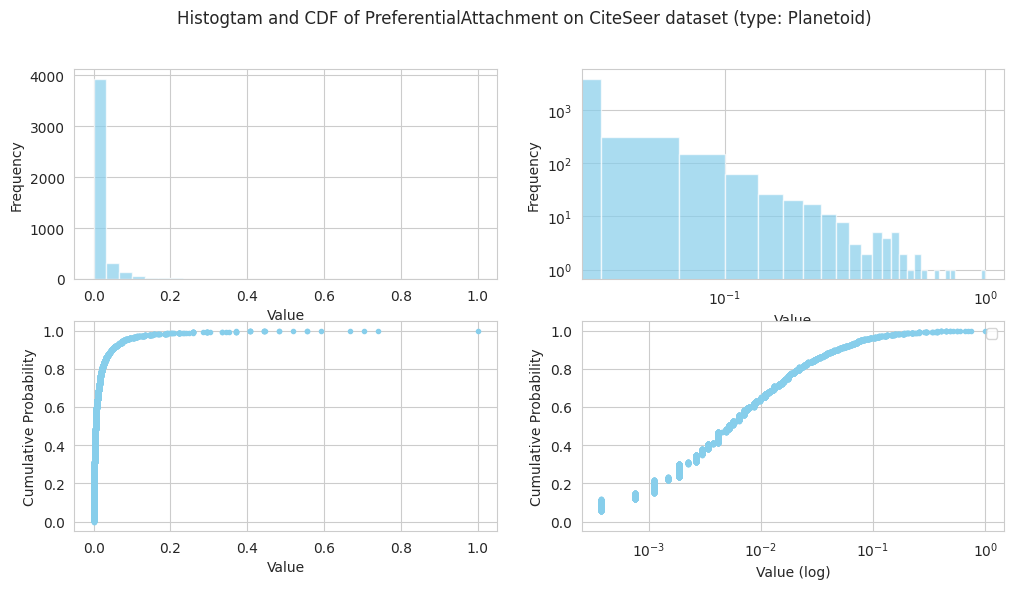

Jaccard()
CiteSeer


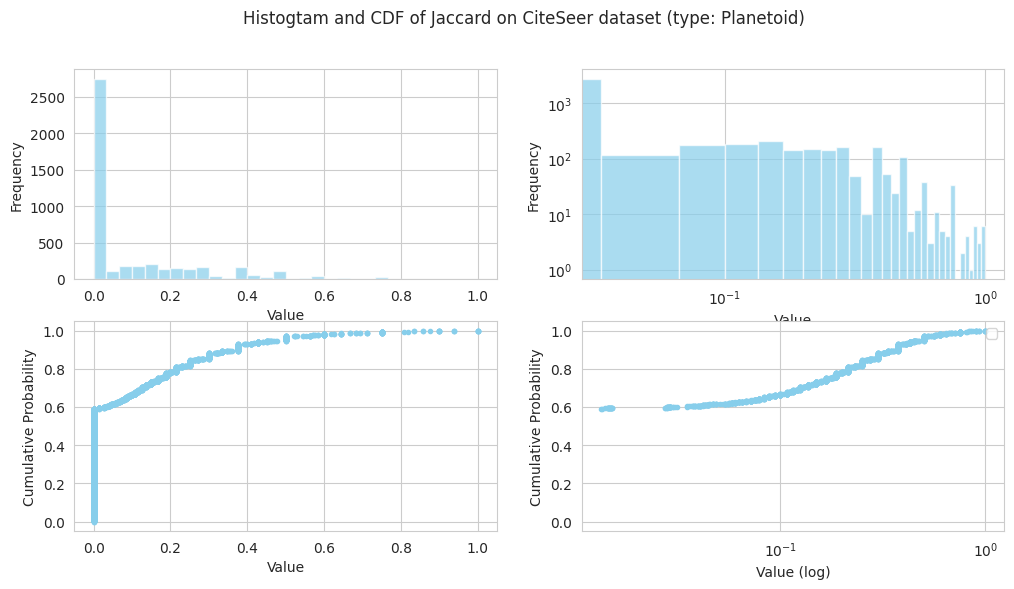

CommonNeighbor()
CiteSeer


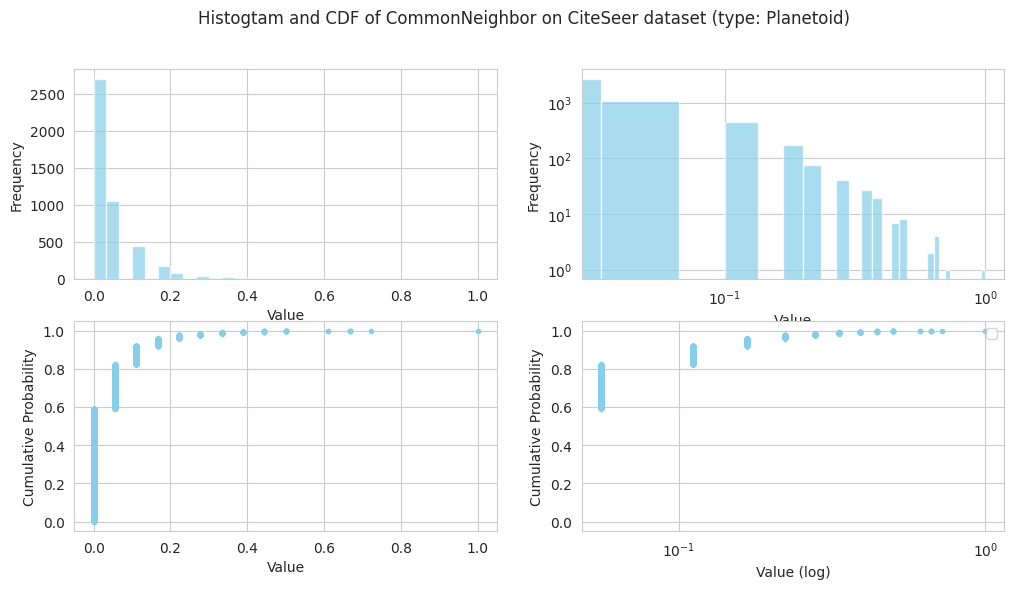

AdamicAdar()
CiteSeer


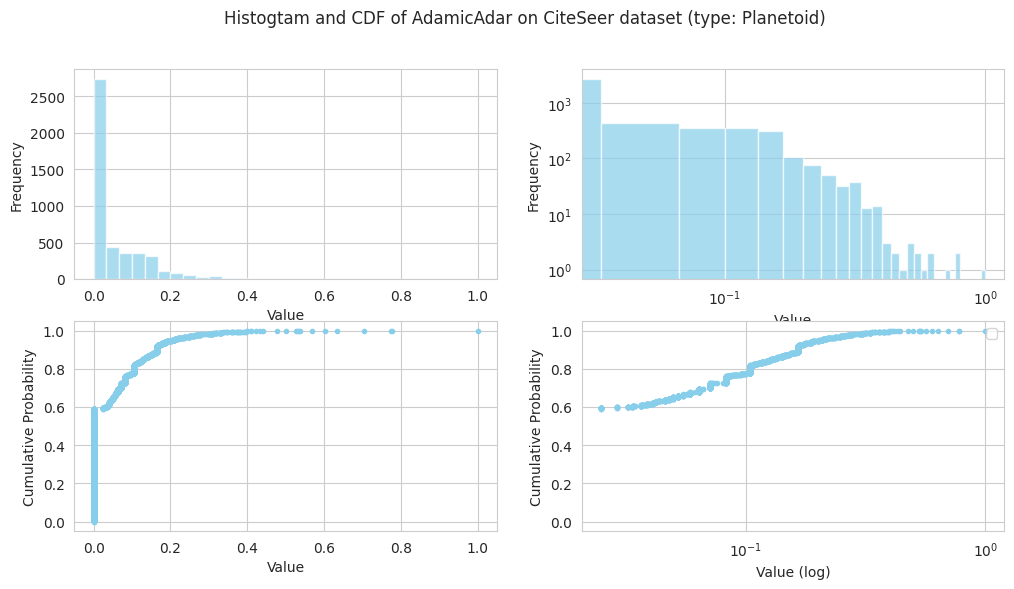

AdjustedRand()
CiteSeer


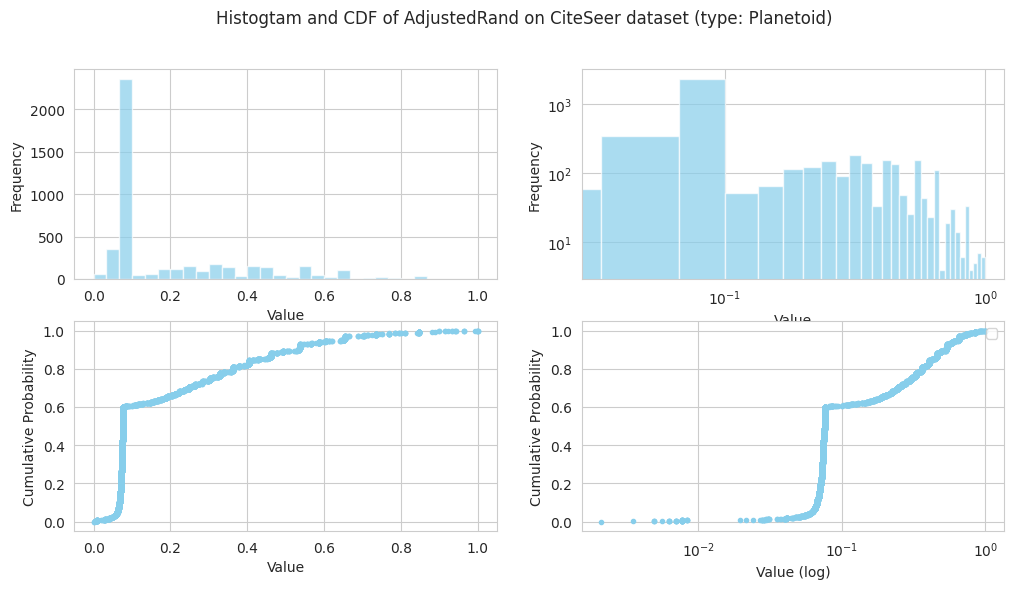

Katz()
CiteSeer


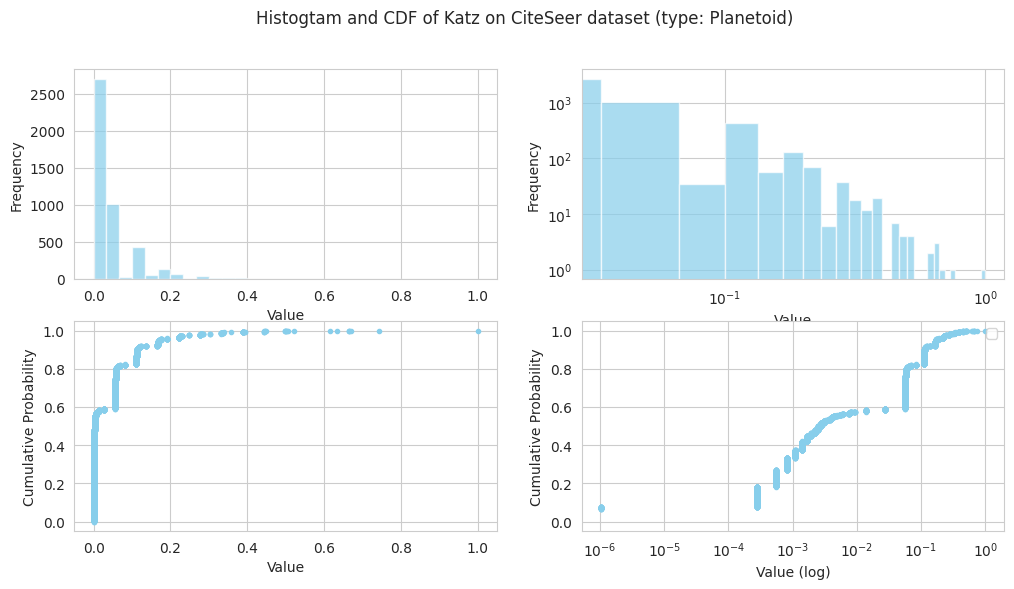

LDS()
CiteSeer


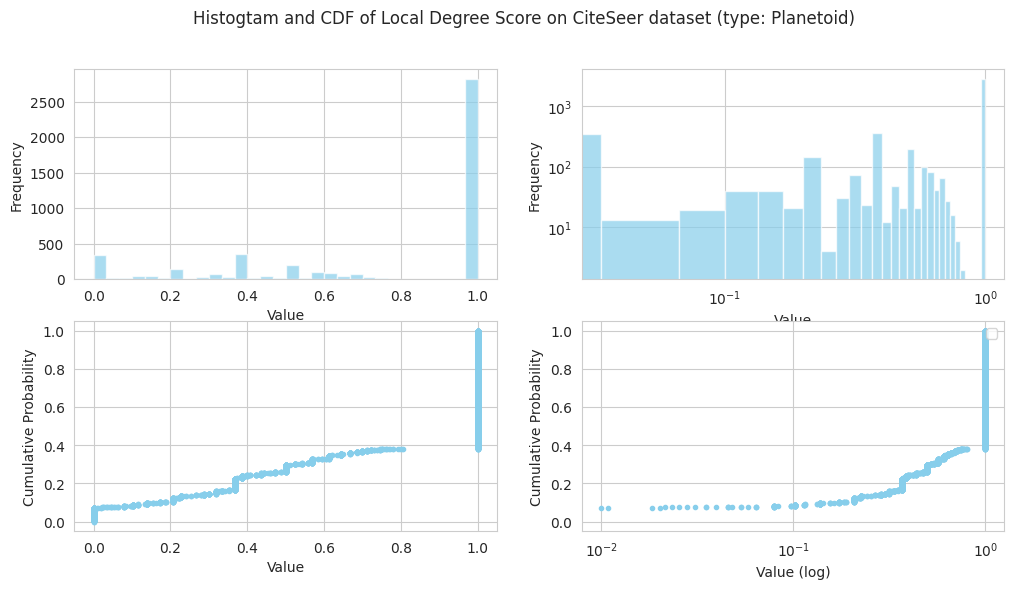

ForestFire()
CiteSeer


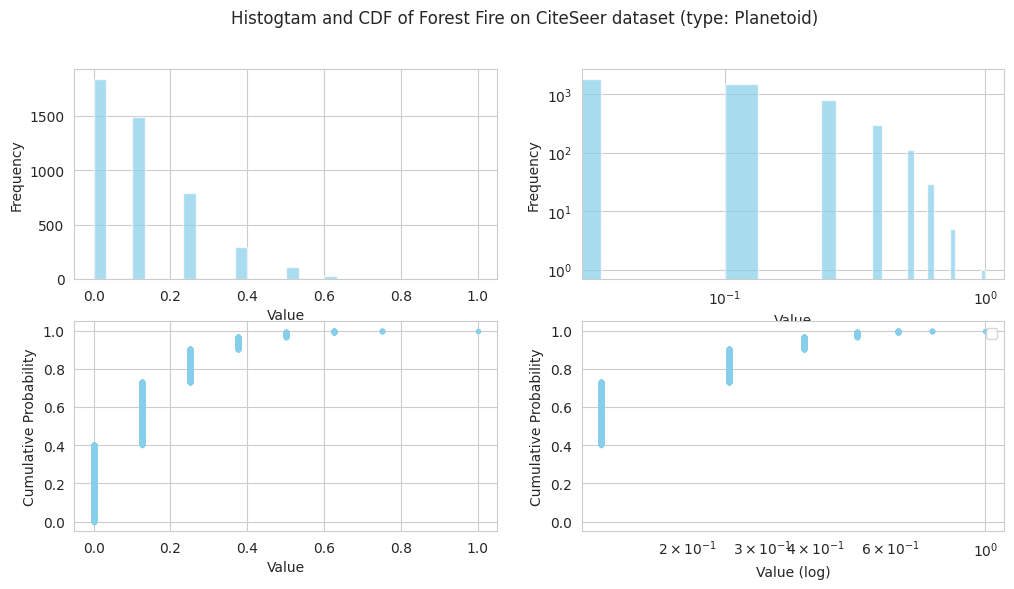

PreferentialAttachment()
PubMed


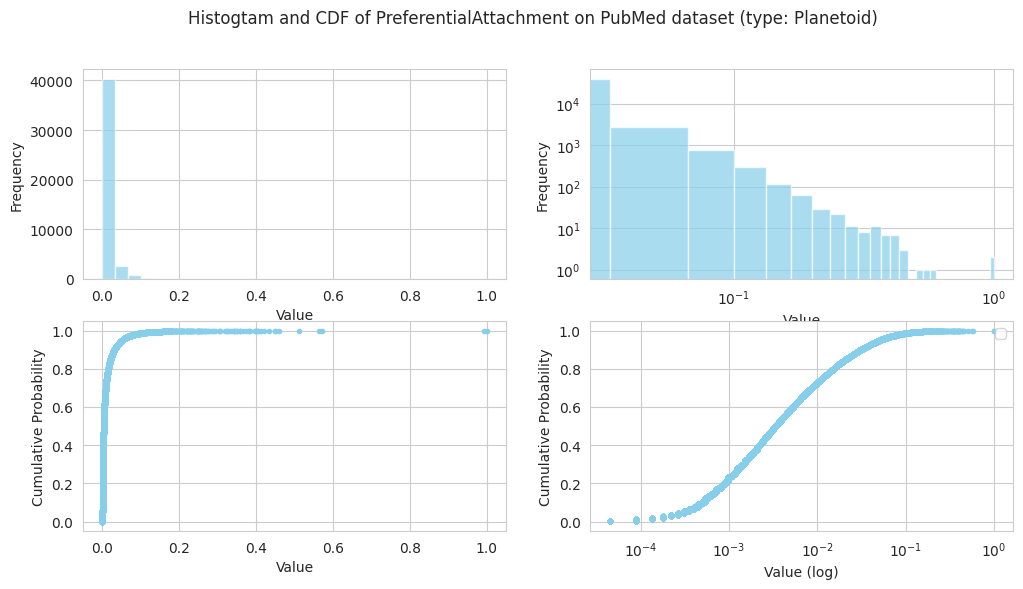

Jaccard()
PubMed


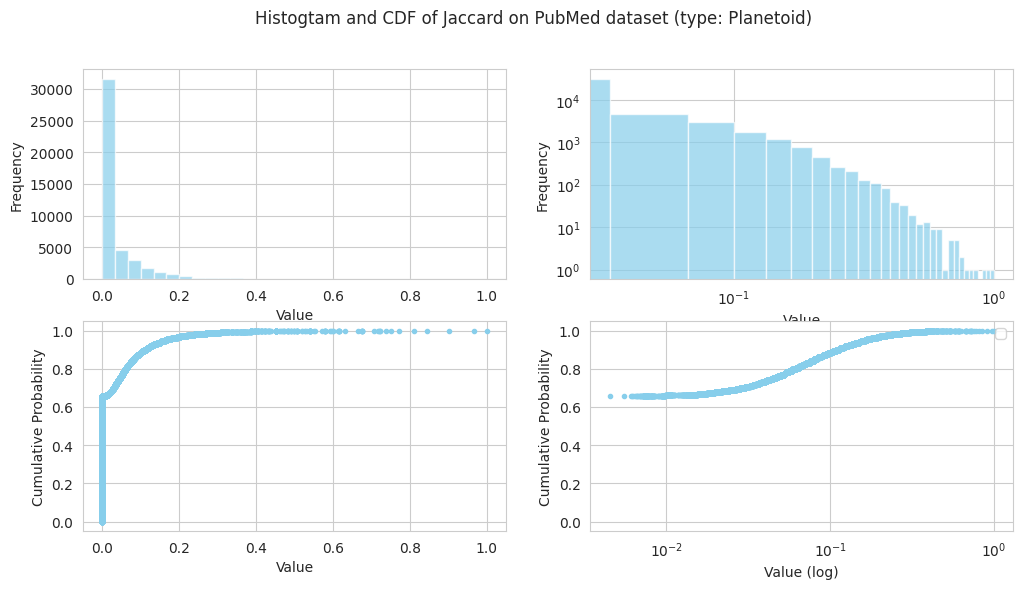

CommonNeighbor()
PubMed


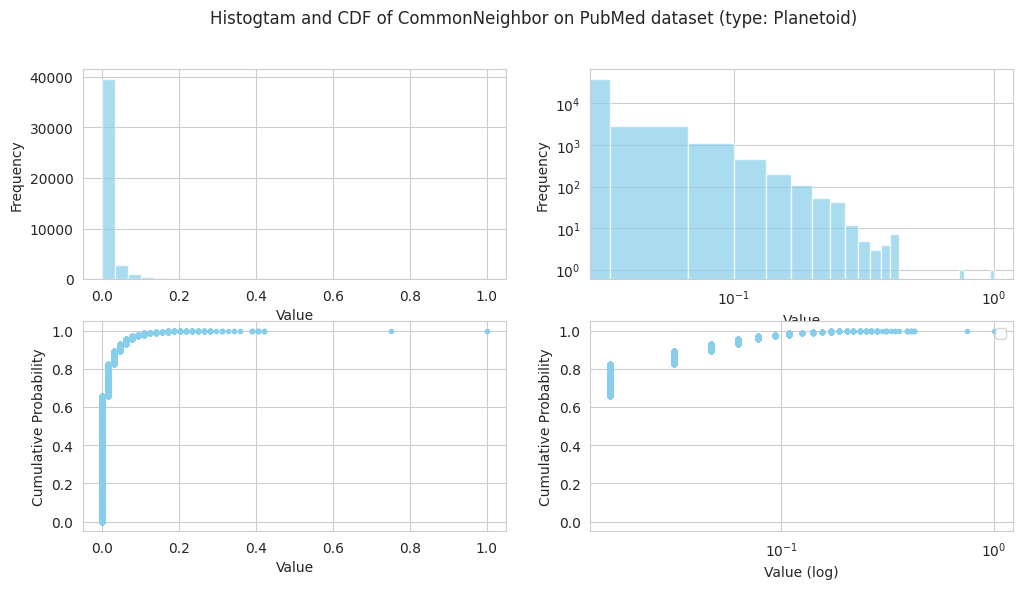

AdamicAdar()
PubMed


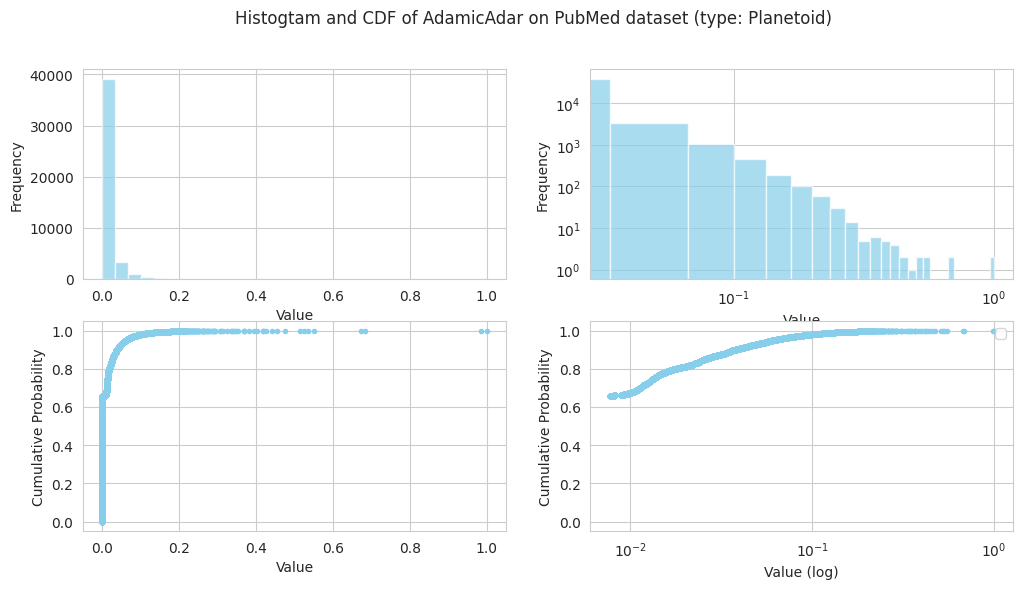

AdjustedRand()
PubMed


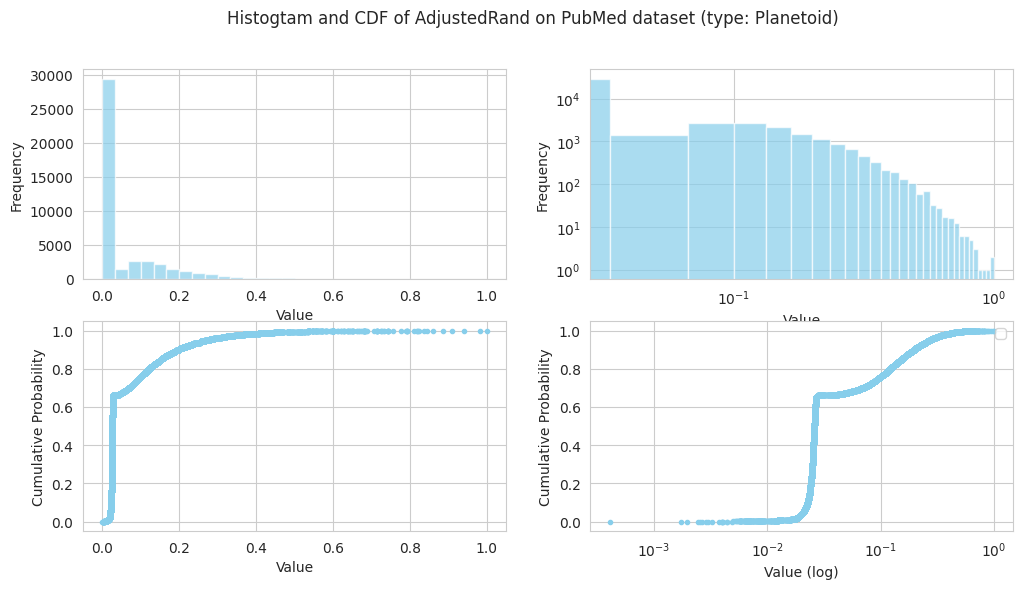

Katz()
PubMed


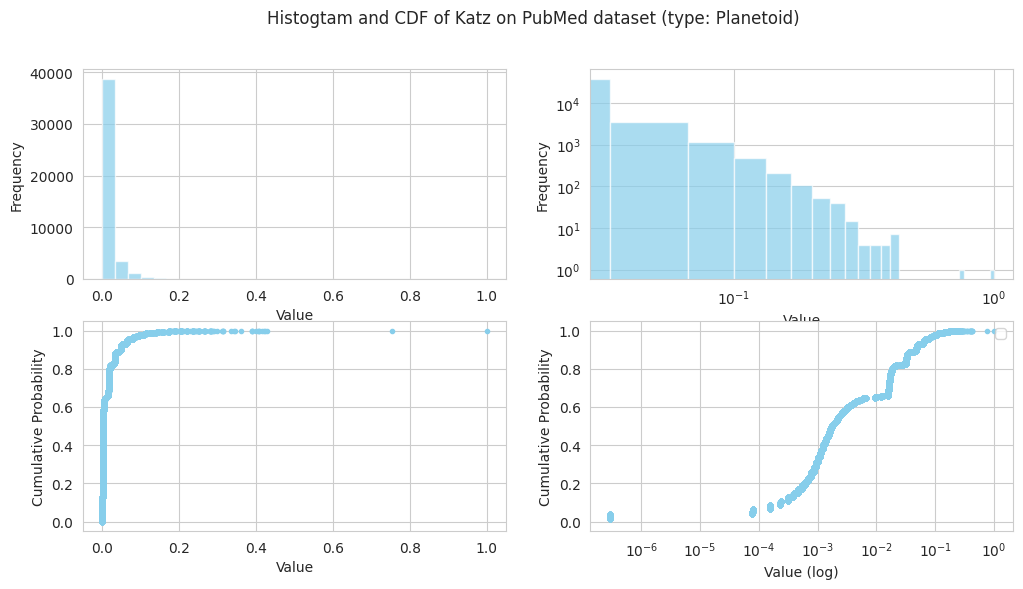

LDS()
PubMed


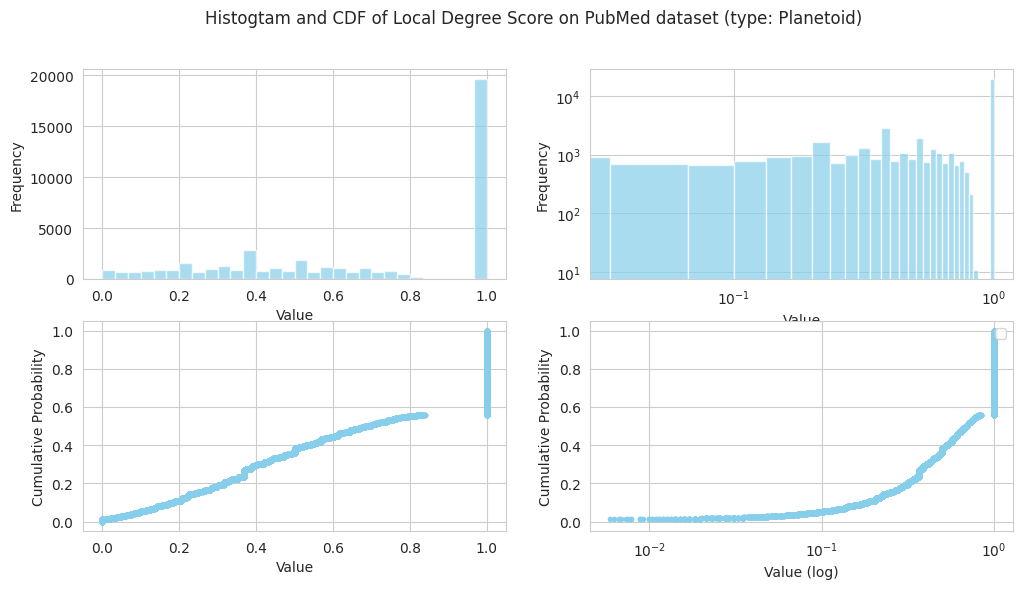

ForestFire()
PubMed


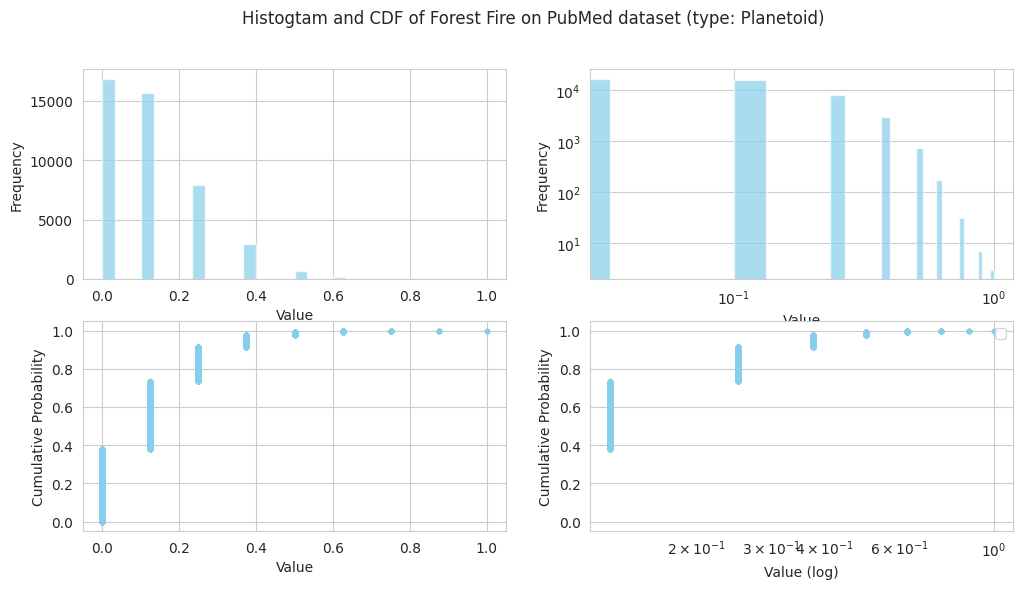

PreferentialAttachment()
Physics


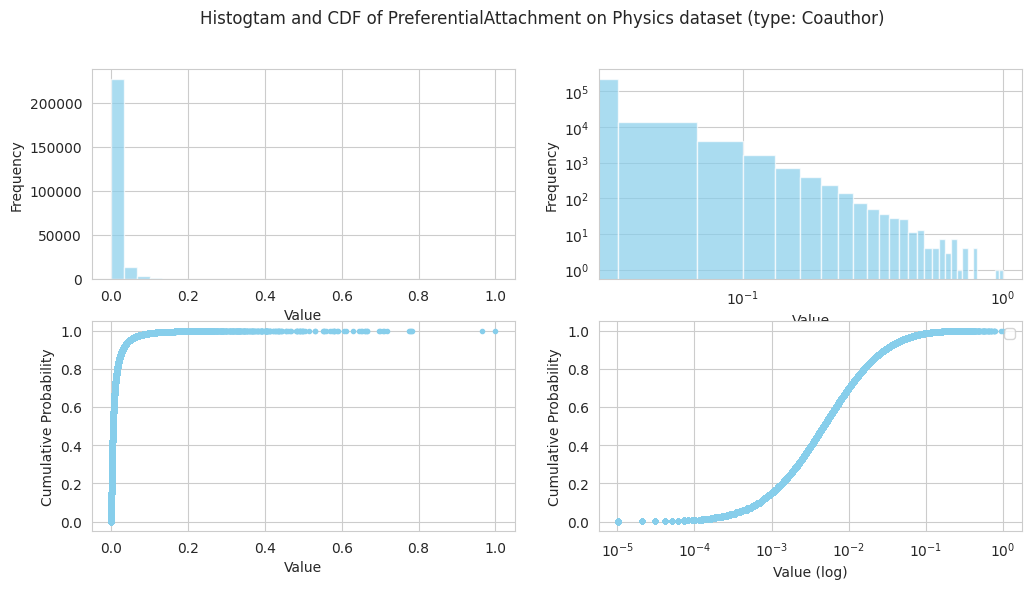

Jaccard()
Physics


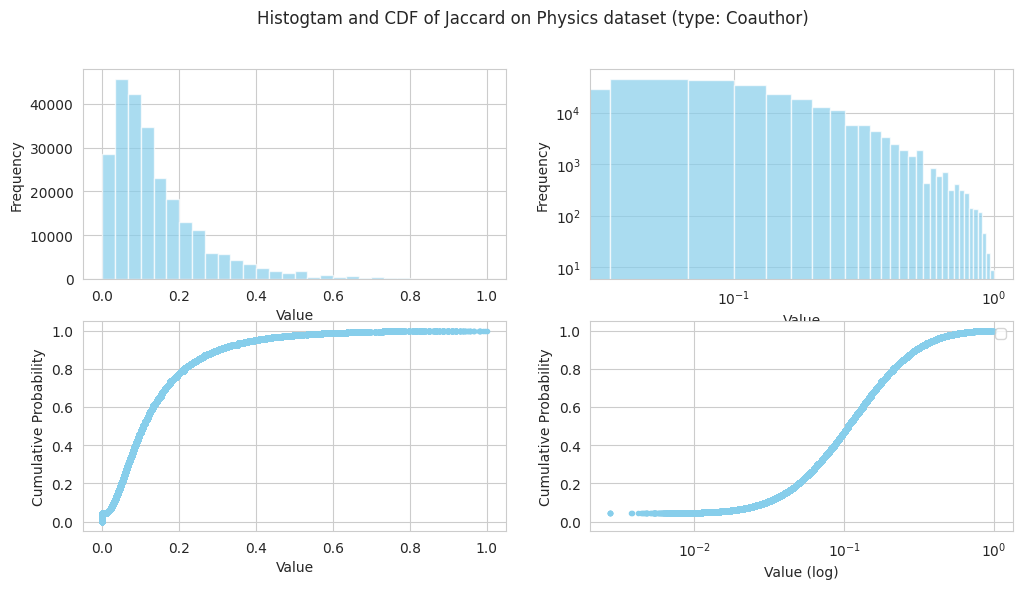

CommonNeighbor()
Physics


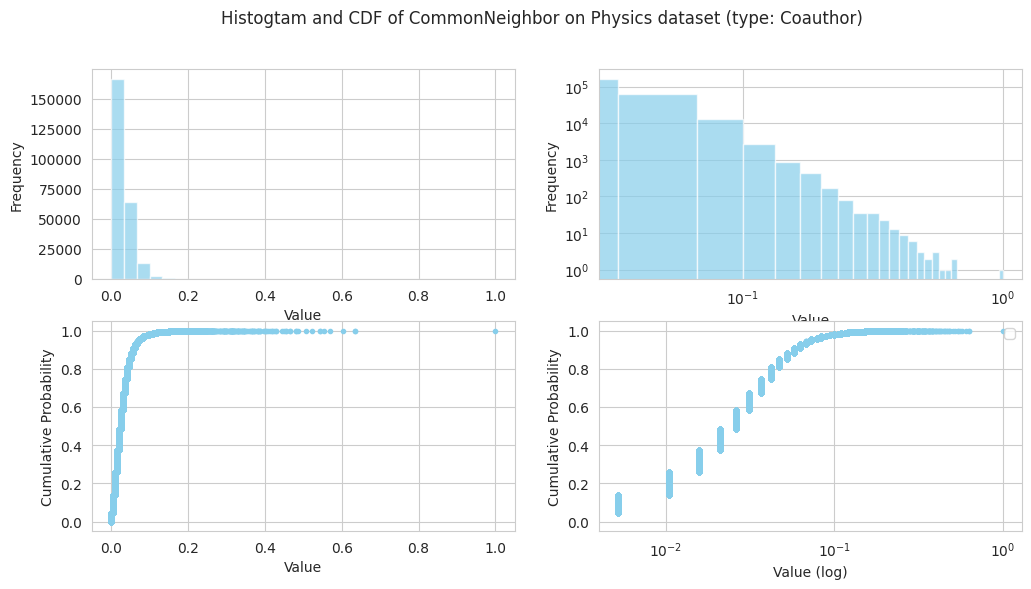

AdamicAdar()
Physics


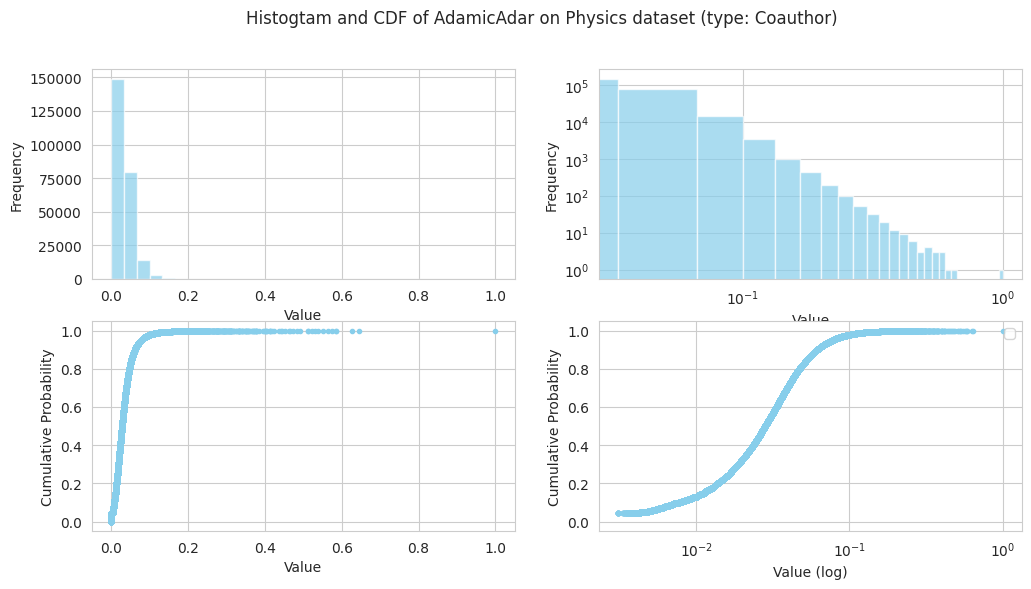

AdjustedRand()
Physics


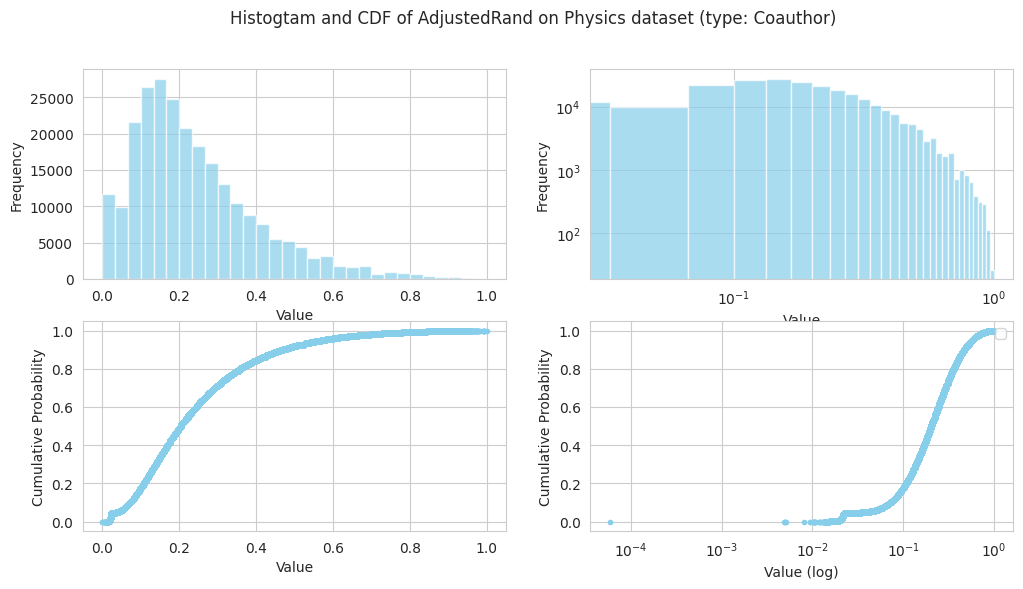

Katz()
Physics


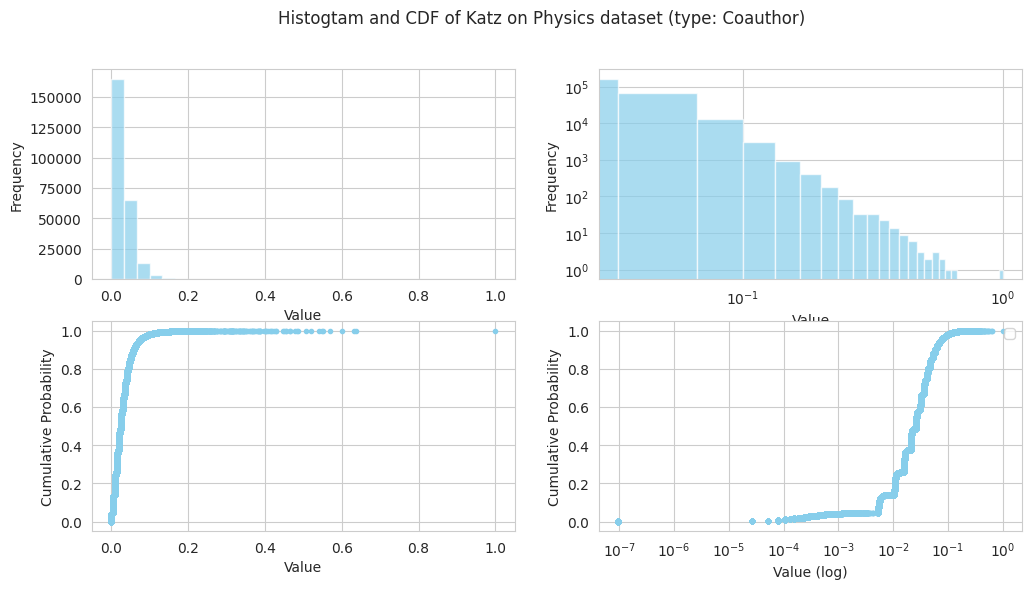

LDS()
Physics


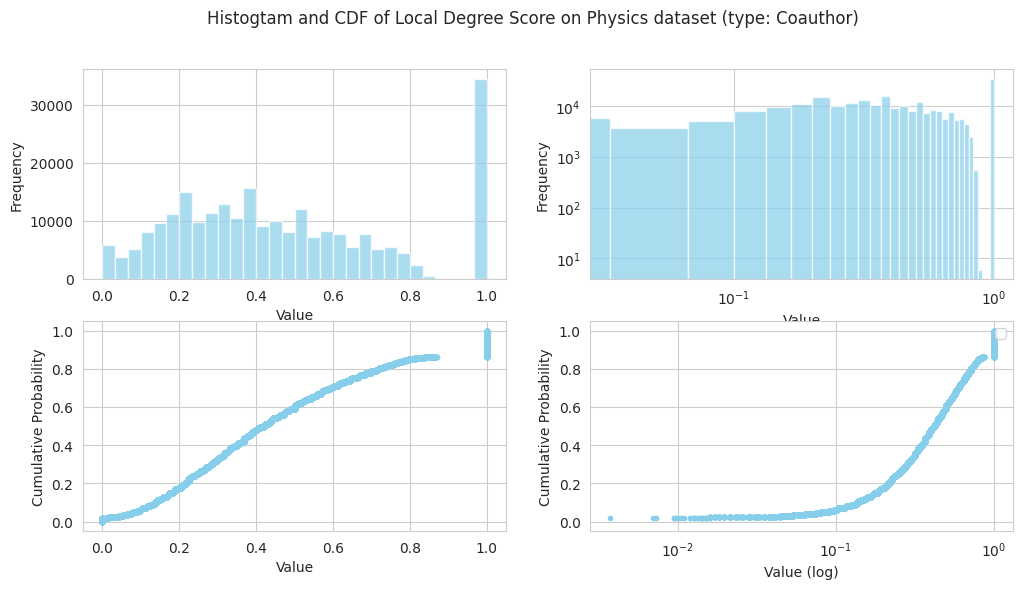

ForestFire()
Physics


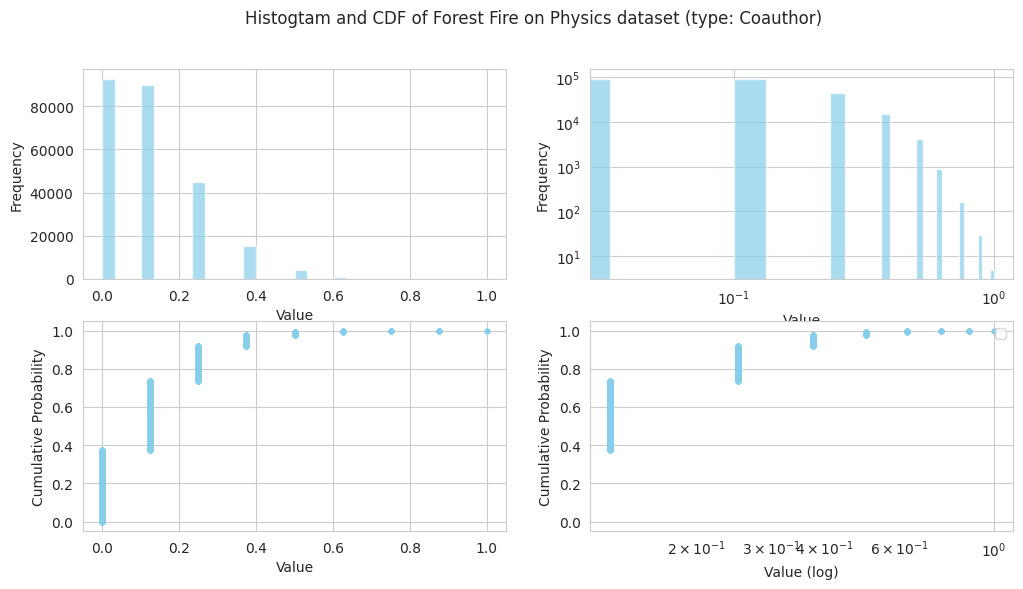

PreferentialAttachment()
CS


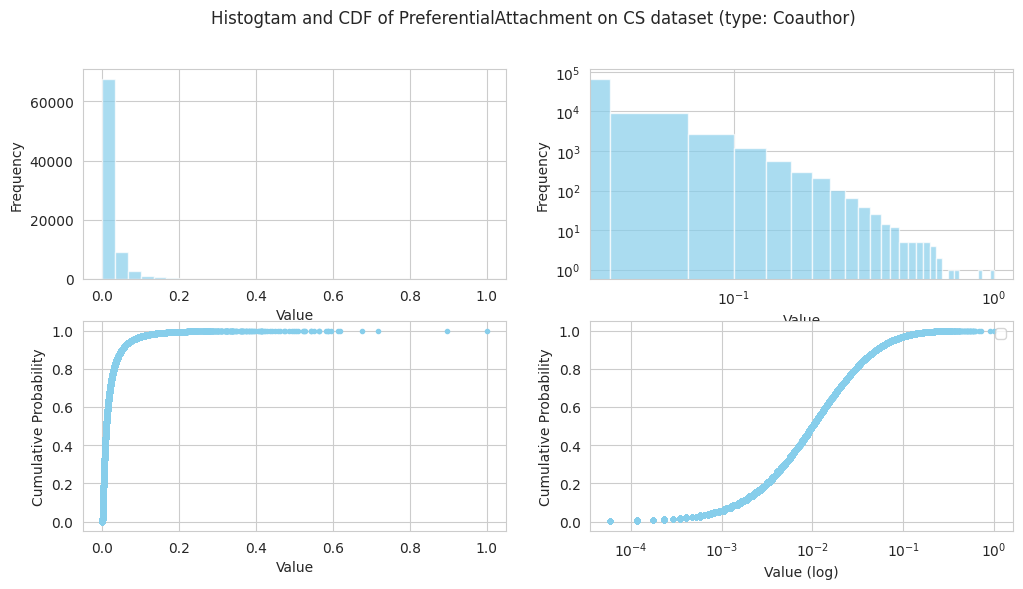

Jaccard()
CS


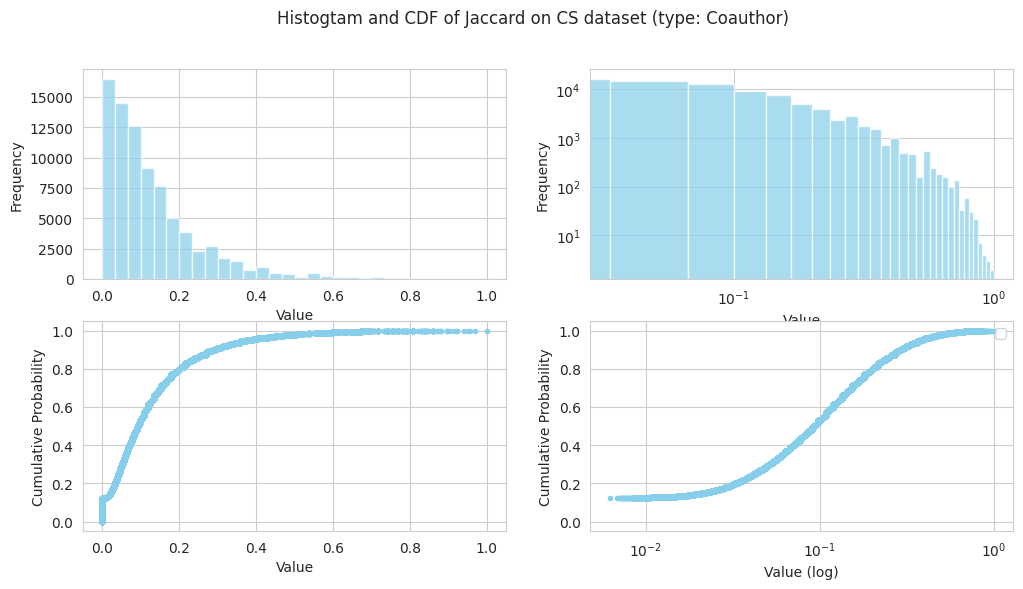

CommonNeighbor()
CS


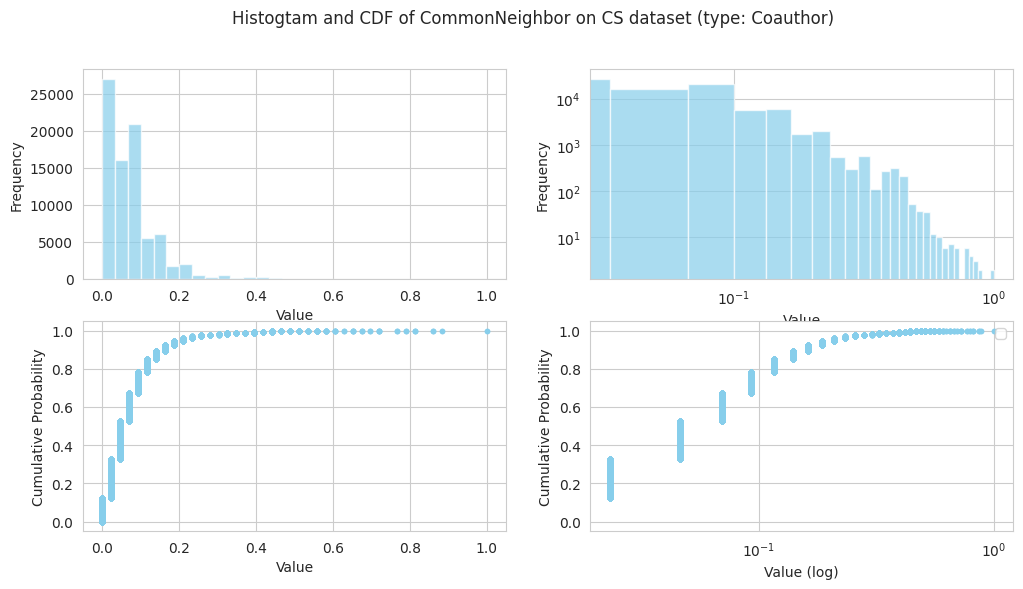

AdamicAdar()
CS


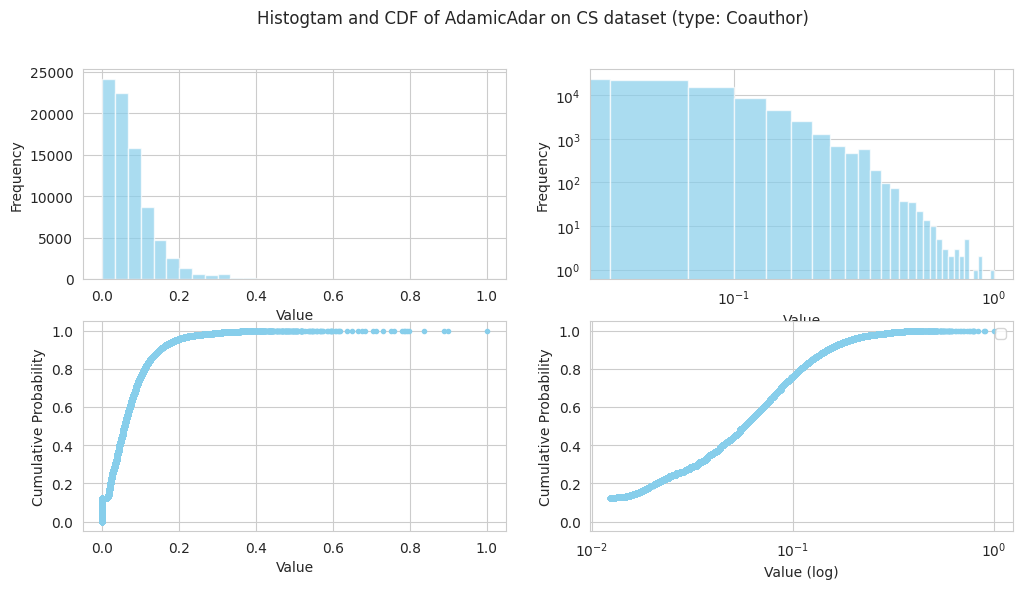

AdjustedRand()
CS


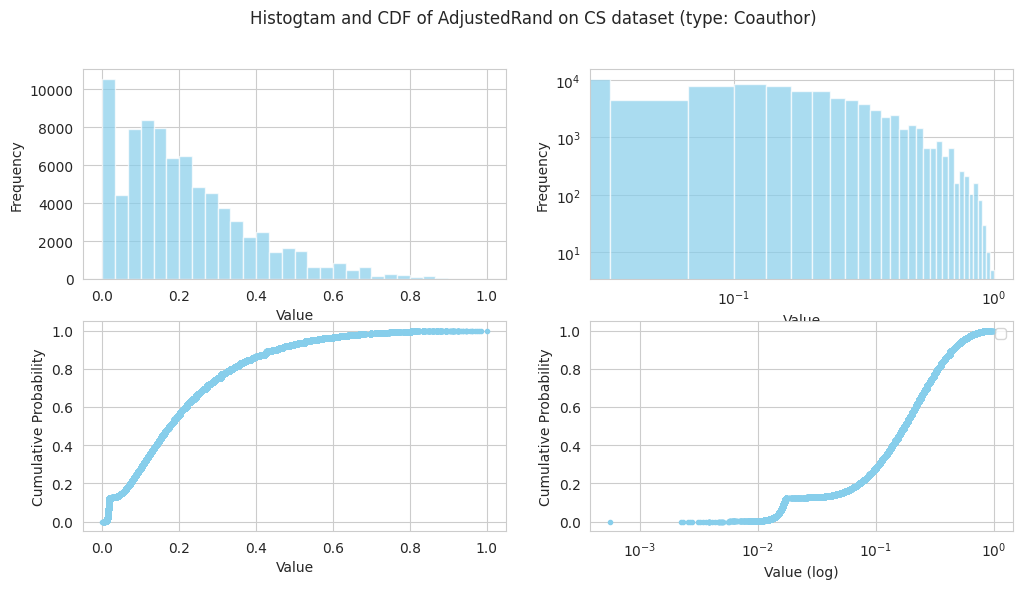

Katz()
CS


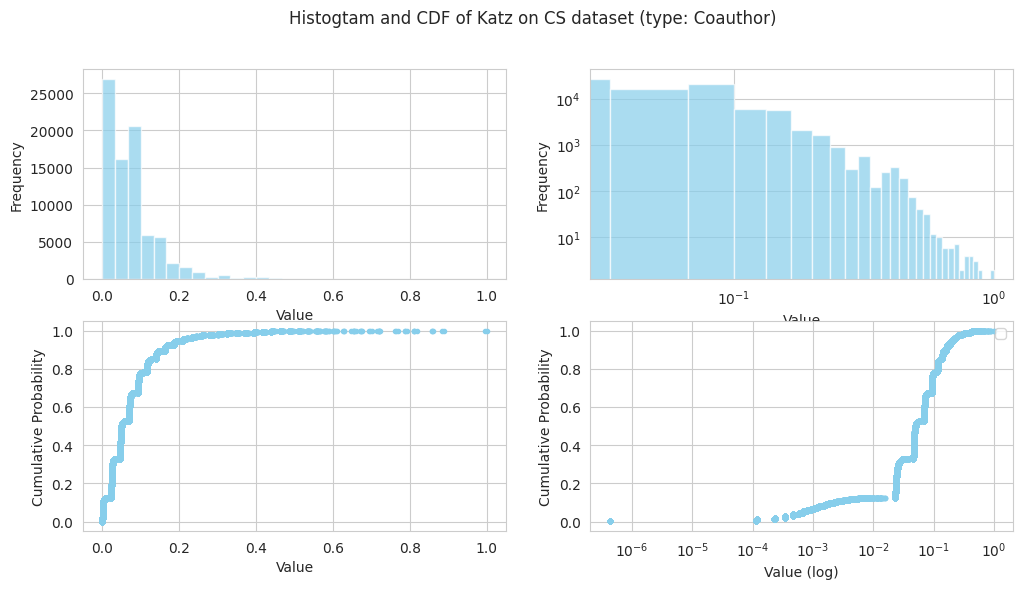

LDS()
CS


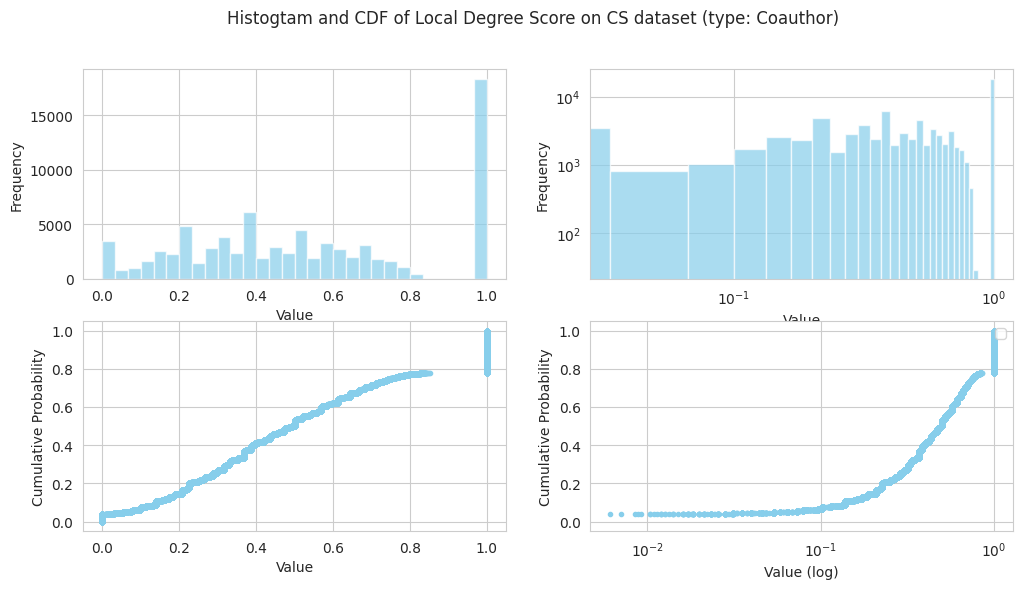

ForestFire()
CS


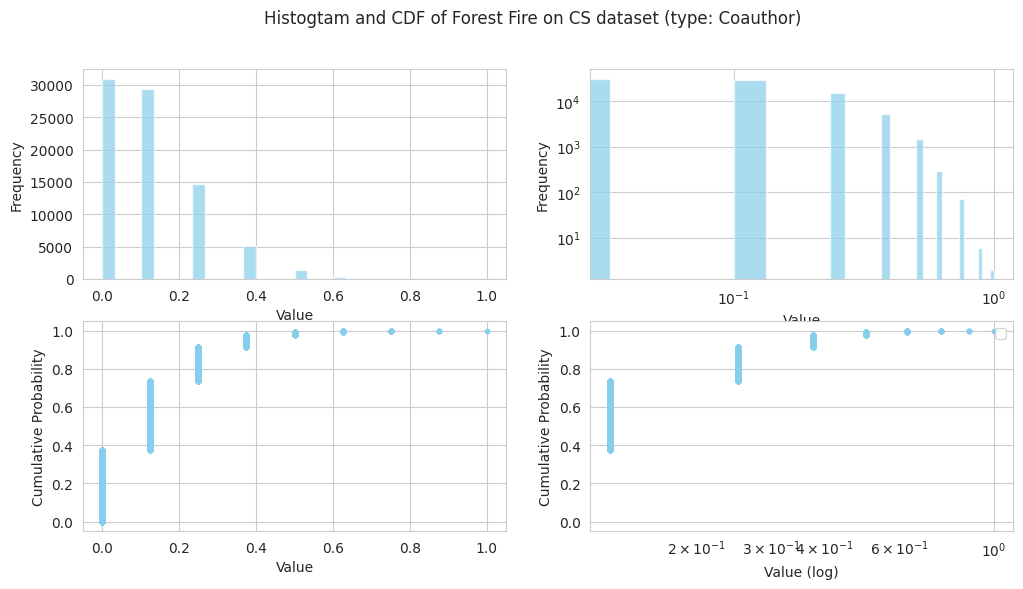

In [12]:
from tqdm import tqdm

#device = torch.device('cuda')
#print(f'Using device: {device}')

def call_exp(sparsing_alg, string):
  acc = [run_exp(
      dataset,
      sparsing_alg=sparsing_alg,
      model_type=model_type
      ) for _ in range(run_num)]
  print(f'{model_name} on {dataset} with {string} sparsing: {torch.tensor(acc).mean():.2%} ± {torch.tensor(acc).std():.2%}')

custom_models = [GCN, SGC]
custom_model_names = ["GCN_CUSTOM", "SGC"]
pretrained_models = [GCN, GraphSAGE, GIN, PNA, GAT] # morgul
pretrained_models = ["GCN", "GraphSAGE", "GIN", "PNA", "GAT"]

for dataset in datasets:
  for model_type, model_name in zip([GCN_CUSTOM], ["GCN_CUSTOM"]):
    run_num = 1 #TODO
    POWER = 0.1
    for sparsing_alg in [PreferentialAttachment(POWER), Jaccard(POWER), CommonNeighbor(POWER), AdamicAdar(POWER), AdjustedRand(POWER), Katz(POWER), LDS(POWER), ForestFire(POWER)]:
      print(sparsing_alg)
      print(dataset[1])
      sparsing_alg(dataset[0][0], dataset[1], dataset[2])